In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from numpy.typing import NDArray

plt.rcParams.update({"axes.grid": True, "font.size": 14})

In [69]:
def bin2dec(bin: NDArray, n: int) -> NDArray:
    bin = bin.reshape(-1, n)
    bin = np.sum(bin * 2 ** np.arange(n)[::-1], axis=1)
    return bin


def qammod(data: NDArray, M: int) -> NDArray:
    """
    QAM modulation function.

    Parameters:
    data : array_like
        The input data symbols to be modulated.
    M : int
        The order of the QAM modulation (e.g., 16 for 16-QAM).

    Returns:
    modulated_signal : ndarray
        The modulated QAM signal.
    """

    # Generate the constellation points
    constellation = np.array(
        [
            complex(i, j)
            for i in range(-int(np.sqrt(M)) + 1, int(np.sqrt(M)), 2)
            for j in range(-int(np.sqrt(M)) + 1, int(np.sqrt(M)), 2)
        ]
    )

    # Map input data to constellation points
    modulated_signal = constellation[data]

    return modulated_signal

In [70]:
info = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0])  # Informação
M = 16  # Número de símbolos da modulação
n = np.log2(M).astype(int)  # Número de bits por símbolo
Rb = 1024  # Taxa de bits [bps]
Rs = Rb / n  # Taxa de símbolos [baud]
Tb = 1 / Rb  # Tempo de bit
Ts = 1 / Rs  # Tempo de símbolo
t = np.arange(0, n * Ts, Ts / (M**2))  # Eixo do tempo
fc = 1000  # Frequência da portadora

In [71]:
symbols = bin2dec(info, n)
symbols

array([ 1,  8,  5, 12])

[-3.-1.j  1.-3.j -1.-1.j  3.-3.j]


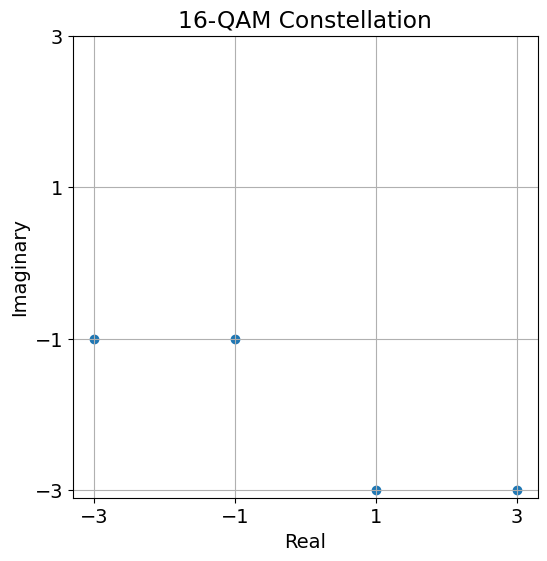

In [72]:
modulated = qammod(symbols, M)
print(modulated)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(modulated.real, modulated.imag)

ax.set_xticks(np.arange(-3, 4, 2))
ax.set_yticks(np.arange(-3, 4, 2))

ax.set_title("16-QAM Constellation")
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")

plt.show()

I: [-3.  1. -1.  3.]
Q: [-1. -3. -1. -3.]


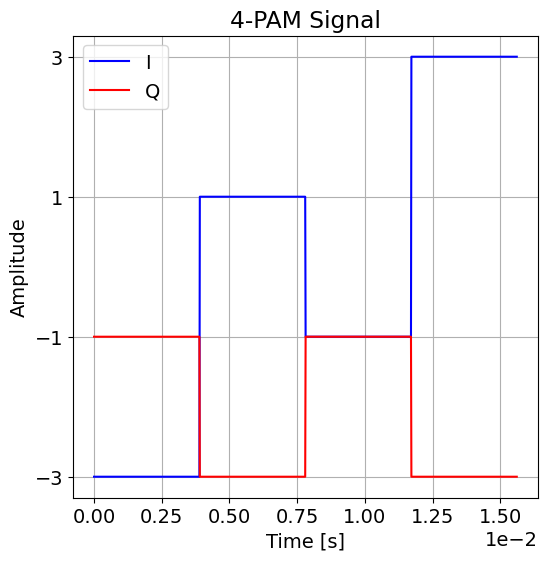

In [73]:
I = modulated.real
Q = modulated.imag

# NRZ upsample
I_4pam = np.repeat(I, Rs)
Q_4pam = np.repeat(Q, Rs)

print("I:", I)
print("Q:", Q)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(t, I_4pam, "b")
ax.plot(t, Q_4pam, "r")

ax.set_yticks(np.arange(-3, 4, 2))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

ax.set_title("4-PAM Signal")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")

ax.legend(["I", "Q"])

plt.show()

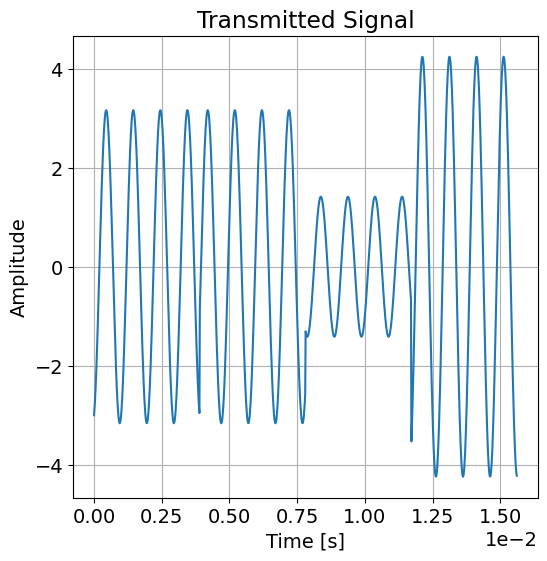

In [76]:
tx = I_4pam * np.cos(2 * np.pi * fc * t) - Q_4pam * np.sin(2 * np.pi * fc * t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(t, tx)

ax.set_title("Transmitted Signal")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")

ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

plt.show()

### Demodulação

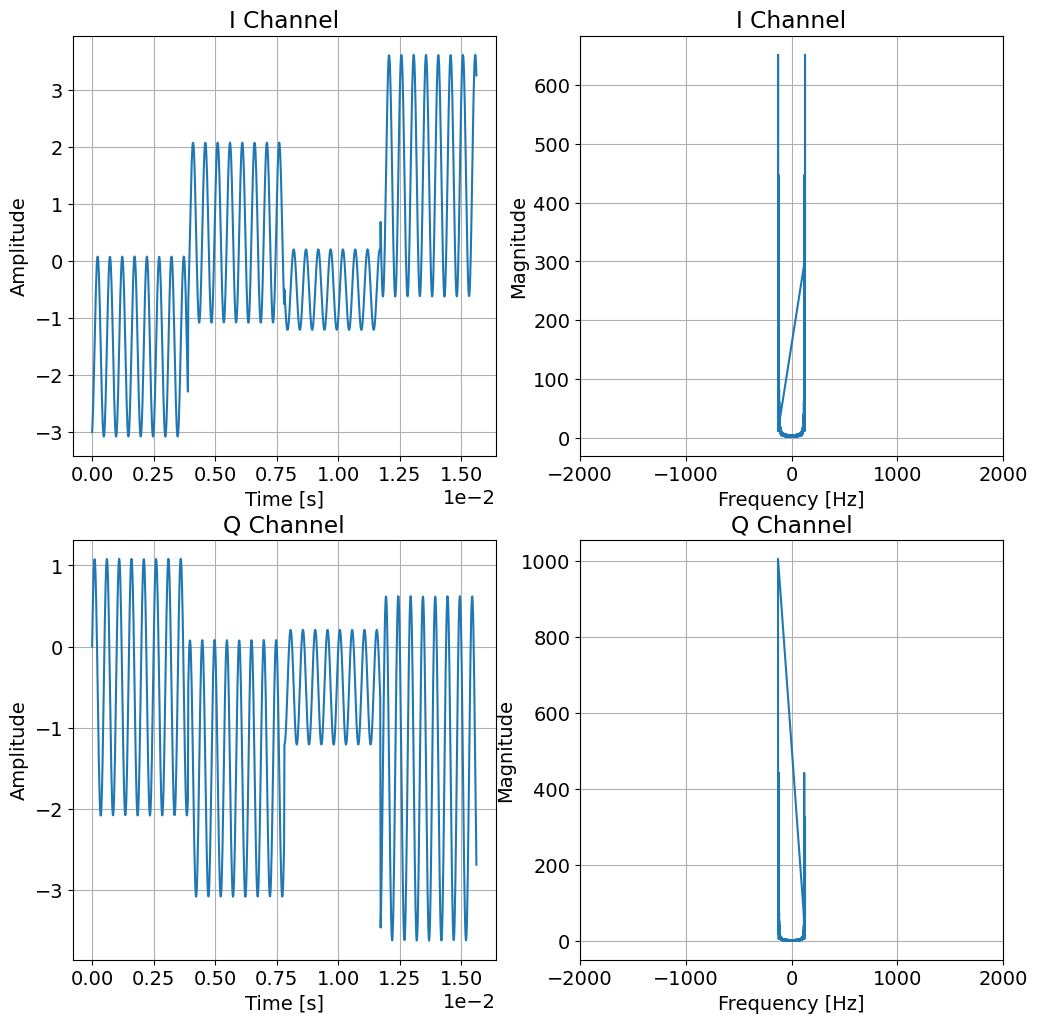

In [95]:
I_rx = tx * np.cos(2 * np.pi * fc * t)
I_RX = np.fft.fft(I_rx)
I_RX = np.fft.fftshift(I_RX)

Q_rx = -tx * np.sin(2 * np.pi * fc * t)
Q_RX = np.fft.fft(Q_rx)
Q_RX = np.fft.fftshift(Q_RX)

f = np.fft.fftfreq(len(t), Ts)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(t, I_rx)
ax[0, 0].set_title("I Channel")
ax[0, 0].set_xlabel("Time [s]")
ax[0, 0].set_ylabel("Amplitude")
ax[0, 0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

ax[0, 1].plot(f, np.abs(I_RX))

ax[0, 1].set_title("I Channel")
ax[0, 1].set_xlabel("Frequency [Hz]")
ax[0, 1].set_ylabel("Magnitude")
ax[0, 1].set_xlim(-2000, 2000)

ax[1, 0].plot(t, Q_rx)
ax[1, 0].set_title("Q Channel")
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel("Amplitude")
ax[1, 0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

ax[1, 1].plot(f, np.abs(Q_RX))
ax[1, 1].set_title("Q Channel")
ax[1, 1].set_xlabel("Frequency [Hz]")
ax[1, 1].set_ylabel("Magnitude")
ax[1, 1].set_xlim(-2000, 2000)


plt.show()